In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

For this data analysis, we will plot time series in order to make comparisons. The two following functions are build to do it.

In [2]:
#Take one time serie and plot
def plot_time_serie(df, ylabel="", xlabel="", title=""):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df, linestyle='-')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xlim(df.index.min(), df.index.max())
    plt.show()

In [3]:
#Take multiple time series and plot them together
def plot_time_series(dfs, names, ylabel="", xlabel="", title="", position = 'upper left'):
    fig, ax = plt.subplots(figsize=(15,6))
    if isinstance(dfs, pd.DataFrame): 
        dfs =[dfs[name] for name in names]
    for df, name in zip(dfs, names):
        ax.plot(df, linestyle='-', label=name)
        ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel(ylabel)
    ax.legend(loc=position)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

We decided to take a look on exchanges of honey and beehives through the last decades. We will thus use the FAOSTAT_Trade_Matrix on the honey and beehives fields and the FAOSTAT_Livestock_Primary dataset in complement for our future analysis.

Side note: The FAO datasets are unreadable with the default pandas encoding utf-8 since they are encoded in latin_1, we must notify it when we read them.

In [4]:
trade_matrix = pd.read_csv("data/FAOSTAT_Trade_Matrix.csv", encoding="latin_1")
honey_production_raw = pd.read_csv("data/FAOSTAT_Livestock_Primary.csv", encoding="latin_1")

Let's first take a look at the total production of honey .

In [5]:
honey_production = honey_production_raw[(honey_production_raw["Item"] == "Honey, natural") & (honey_production_raw["Unit"] == "tonnes")]
honey_production = honey_production[["Area", "Year", "Value"]]
honey_production = honey_production.rename(columns={"Area": "Country", "Value": "Production Value"})

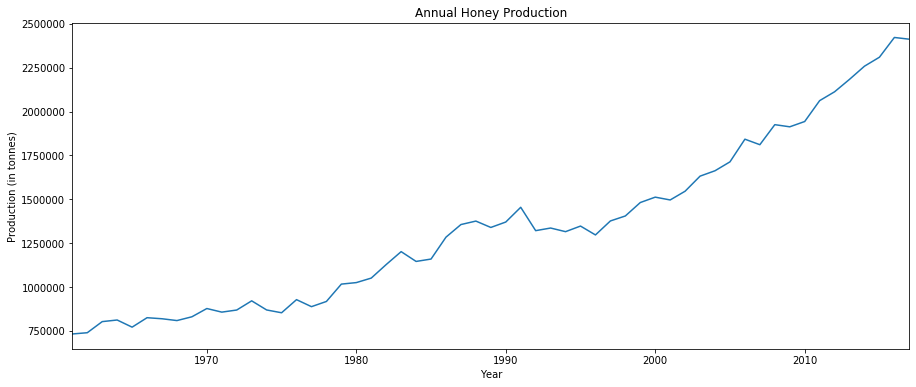

In [6]:
honey_year_production = honey_production.groupby("Year")["Production Value"].sum()
plot_time_serie(honey_year_production, 'Production (in tonnes)', 'Year', 'Annual Honey Production')

We can observe that the honey production increased since the 60s. 

Now let's see the Trade matrix.

In [7]:
def print_corrcoef(exports, imports, name):
    print(f"The correlation between imports and exports of {name} is {exports.corr(imports, method='pearson')}.")

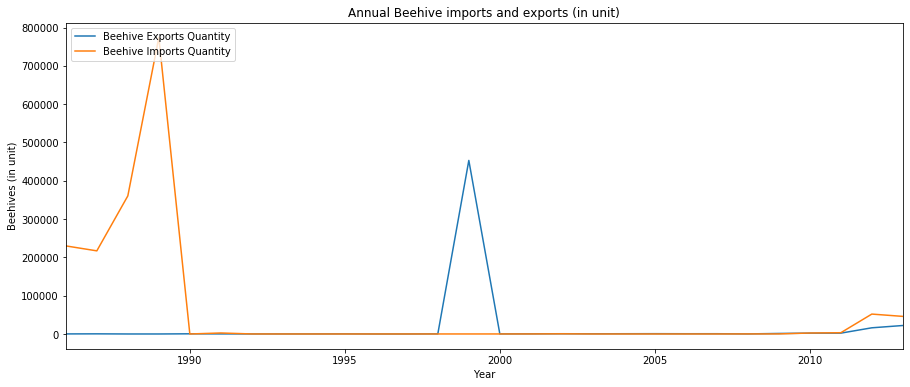

The correlation between imports and exports of beehives (in unit) is -0.07476498880707769.


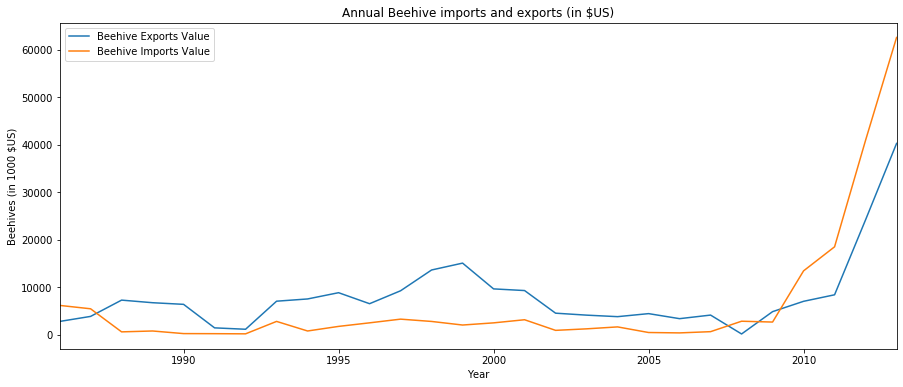

The correlation between imports and exports of beehives (in 1000 $US) is 0.8813326996733277.


In [8]:
beehives = trade_matrix[(trade_matrix["Item"] == "Beehives")]

beehives_imports = beehives[(beehives["Element"] == "Import Quantity")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Quantity")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Quantity', 'Beehive Imports Quantity'], "Beehives (in unit)", "Year", "Annual Beehive imports and exports (in unit)")
print_corrcoef(exports, imports, "beehives (in unit)")
      
beehives_imports = beehives[(beehives["Element"] == "Import Value")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Value")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Value', 'Beehive Imports Value'], "Beehives (in 1000 $US)", "Year", "Annual Beehive imports and exports (in $US)")
print_corrcoef(exports, imports, "beehives (in 1000 $US)")

In [9]:
Albania_Macedonia_beehives_trades = beehives[(beehives["Reporter Countries"] == 'Albania') & (beehives["Partner Countries"] == 'North Macedonia') & (beehives["Value"] > 0) & (beehives["Year"] == 2009)]
print(f"We have {Albania_Macedonia_beehives_trades.shape[0]} link between Albania and North Macedonia.")
Albania_Macedonia_beehives_trades

We have 1 link between Albania and North Macedonia.


,Domain Code,Domain,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
289,TM,Detailed trade matrix,3,Albania,154,North Macedonia,5622,Import Value,1181,Beehives,2009,2009,1000 US$,2,NaN,Official data


We should expect the same value of Import and Export beehives per year, which is not the case here (See figures above). We would expect symmetrical behaviour (if export from A to B then import from B to A), which is not the case in the example above. The correlation coefficient is not high enough to use them. Then Beehives exports and imports can not be used here.


In [10]:
honey = trade_matrix[trade_matrix["Item"] == "Honey, natural"]

honey_imports = honey[honey["Element"] == "Import Quantity"]
honey_imports = honey_imports[["Reporter Countries", "Year", "Value"]]
honey_imports = honey_imports.rename(columns={"Reporter Countries": "Country", "Value": "Import Value"})

honey_exports = honey[honey["Element"] == "Export Quantity"]
honey_exports = honey_exports[["Reporter Countries", "Year", "Value", "Partner Countries"]]
honey_exports = honey_exports.rename(columns={"Reporter Countries": "Country", "Value": "Export Value"})

We will now see if the honey imports and exports are more usable.

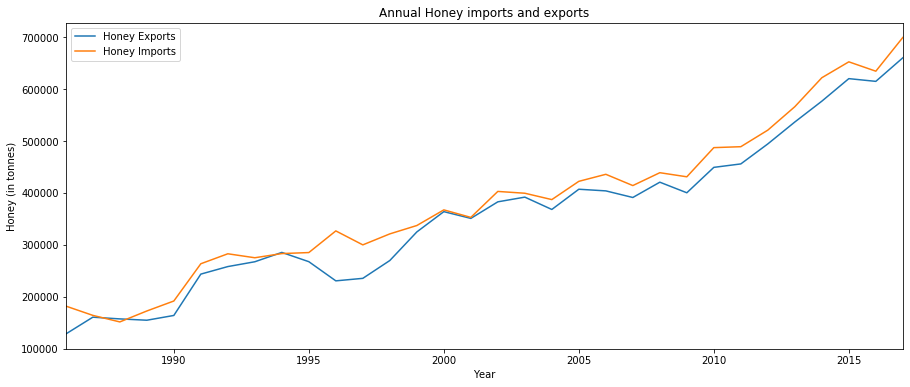

The correlation between imports and exports of honey is 0.9900288530138095.


In [11]:
exports = honey_exports.groupby(["Year"]).sum()["Export Value"]
imports = honey_imports.groupby(["Year"]).sum()["Import Value"]

plot_time_series([exports, imports ], ['Honey Exports', 'Honey Imports'], "Honey (in tonnes)", "Year", "Annual Honey imports and exports")
print_corrcoef(exports, imports, "honey")

We can see that the two curves are very similar, we will focus our analysis on the honey exports and imports since the data seems more usable.

In [12]:
exports_country = honey_exports.groupby(["Year", "Country"]).agg('sum')
imports_country = honey_imports.groupby(["Year", "Country"]).agg('sum')

In [13]:
exports_country.head()

Export Value
Year Country                         
1986 Argentina                  18601
     Australia                   9536
     Austria                       82
     Belgium-Luxembourg          1553
     Belize                       249

We will go deeper in the dataset and try to see how is distributed the honey exports and imports over the world.

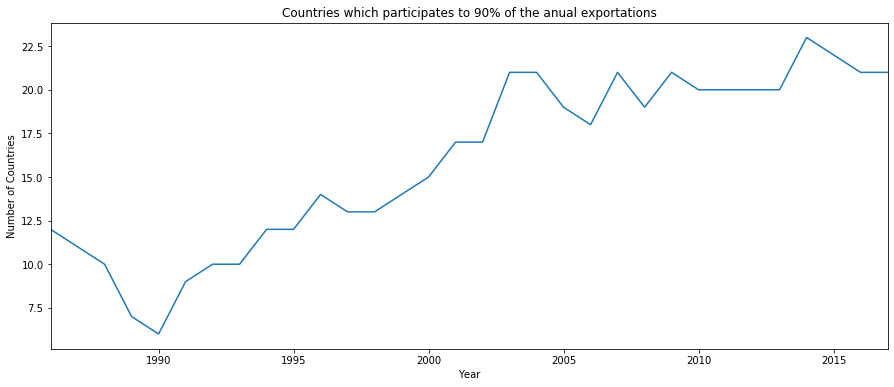

In [14]:
top_exporters = exports_country.copy()
top_exporters.reset_index(inplace=True) 
top_exporters['ratio'] = top_exporters["Export Value"] / top_exporters['Export Value'].groupby(top_exporters['Year']).transform('sum')
top_exporters = top_exporters.sort_values("ratio", ascending = False)
top_exporters["cumulative sum"] = top_exporters["ratio"].groupby(top_exporters['Year']).transform('cumsum')

top_exporters = top_exporters[top_exporters["cumulative sum"]<0.9]
best_exporters = top_exporters.groupby("Year")["Country"]
plot_time_serie(best_exporters.count(), ylabel="Number of Countries", xlabel="Year", title="Countries which participates to 90% of the anual exportations")

We can observe that the number of big honey exporters increased last years. This can show a good health of the honey market, let's see the import data to improve our analysis.

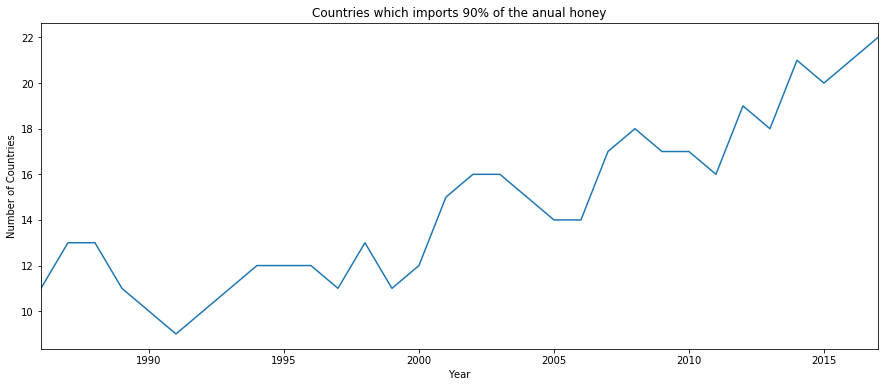

In [15]:
top_importers = imports_country.copy()
top_importers.reset_index(inplace=True) 
top_importers['ratio'] = top_importers["Import Value"] / top_importers['Import Value'].groupby(top_importers['Year']).transform('sum')
top_importers = top_importers.sort_values("ratio", ascending = False)
top_importers["cumulative sum"] = top_importers["ratio"].groupby(top_importers['Year']).transform('cumsum')

top_importers = top_importers[top_importers["cumulative sum"]<0.9]
best_importers = top_importers.groupby("Year")["Country"]
plot_time_serie(best_importers.count(), ylabel="Number of Countries", xlabel="Year", title="Countries which imports 90% of the anual honey")

We can notice that the number of important importers increased, these countries can not produce enough honey for their consumption. These countries can honey consumer which always consumes imported honey or ones which have honey production issue and thus must import honey in order to meet the demand. We will try to identify these countries in the following analysis.

We will try to observe honey exchanges trends for some countries. For that we pick imports and exports values of each country. We also compute a new value for our analysis called the "Honey Consumption"; it represents the quantity of honey which it consumes per year and is compute as follows (for one year, in tonnes): $Honey\ Consumption = Honey\ Production - Honey\ Exports + Honey\ Imports$.

In [16]:
exchanges = pd.merge(honey_production, exports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges = pd.merge(exchanges, imports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges["Honey Consumption"] = exchanges["Production Value"] - exchanges["Export Value"] + exchanges["Import Value"]
exchanges["Balance"] = exchanges["Export Value"] - exchanges["Import Value"]
exchanges = exchanges.set_index('Year')

In [17]:
names = ["Production Value", "Export Value", "Import Value", "Honey Consumption"]
def plot_countries_exchanges(exchanges, countries, position = "upper left"):
    for country in countries:
        country_honey = exchanges[exchanges["Country"] == country]
        plot_time_series(country_honey, names,'Honey (in tonnes)', 'Year', f'Annual Honey Exchanges in {country}', position = position)

#### Multiple kinds of country for exchanges

In [18]:
year = 2017
exchanges_tmp = exchanges.copy()
exchanges_tmp = exchanges_tmp.reset_index()
exchanges_tmp = exchanges_tmp[exchanges_tmp["Year"] == year]

We can see below the best export countries in 2017

In [19]:
exports_country.loc[year].sort_values(by = "Export Value", ascending = False).head(5)

,Export Value
Country,
"China, mainland",129261
Argentina,70322
Ukraine,67905
India,52979
Mexico,27723


And the best import countries in 2017

In [20]:
imports_country.loc[year].sort_values(by = "Import Value", ascending = False).head(5)

,Import Value
Country,
United States of America,202565
Germany,93069
United Kingdom,44983
Japan,42823
France,35546


1) Countries which consumes a lot but don't produce (production is way not enough).

See Japan below

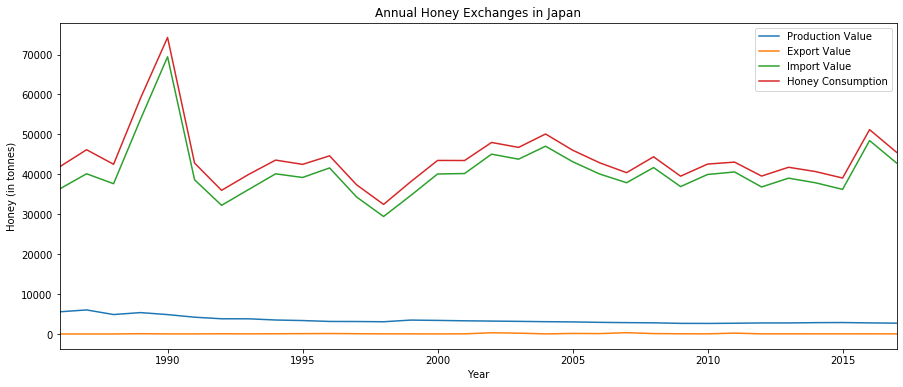

In [21]:
big_importer_country = ["Japan"]
plot_countries_exchanges(exchanges, big_importer_country, position = "upper right")

2) Countries which consumes a lot, produce a lot and import a lot.

United States of America, France

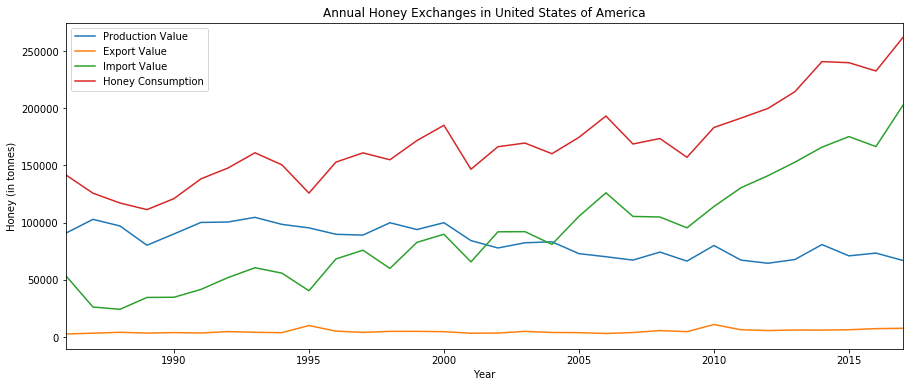

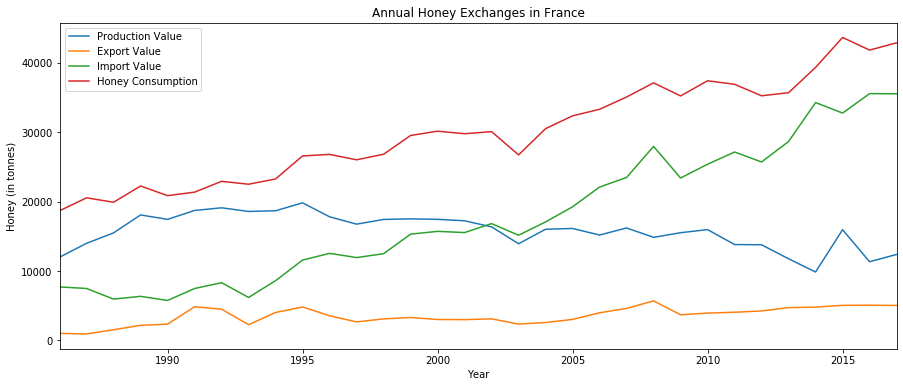

In [22]:
producer_importer_countries = ["United States of America", "France"]
plot_countries_exchanges(exchanges, producer_importer_countries)

We can see in these countries a bad production health, indeed production appears to have declined in favour of the honey importations. These countries are no more self-sufficient and are dependent on other countries ($importations > production$). USA are the biggest importer.

In [23]:
print("The biggest importer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Import Value'].idxmax()]["Country"]))

The biggest importer of 2017 is United States of America


3) Countries that consumes a lot and produce a lot

China is the biggest honey consumer, it is totaly self-sufficient. It is also the biggest producer and thus can export a lot (it is also the biggest exporter).

In [24]:
print("The biggest exporter of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Export Value'].idxmax()]["Country"]))
print("The biggest producer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Production Value'].idxmax()]['Country']))
print("The biggest consumer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Honey Consumption'].idxmax()]["Country"]))

The biggest exporter of 2017 is China, mainland
The biggest producer of 2017 is China, mainland
The biggest consumer of 2017 is China, mainland


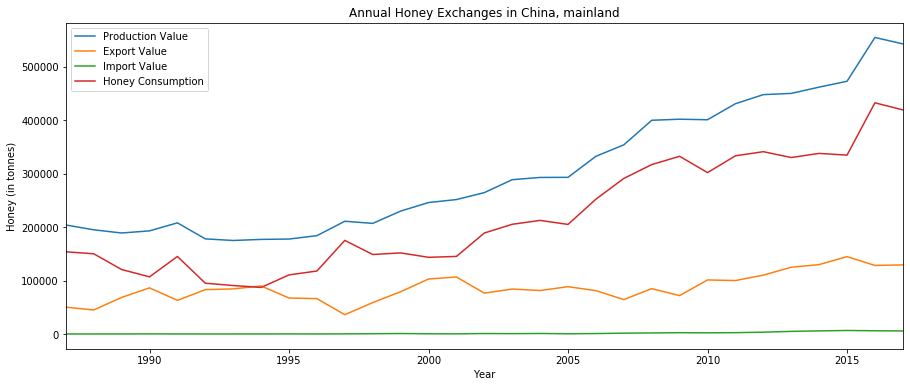

In [25]:
importer_countries = ["China, mainland"]
plot_countries_exchanges(exchanges, importer_countries)

We can observe 3 different kind of countries:
the countries which export the greater part of their honey production (Argentina)
the countries which import the greater part of their honey (France, USA, Japan)
the countries which use the greater part of their honey (China)

4) Countries which only exports

Argentina is a country which is always in the best exporters, however it doesn't consume a lot of it.

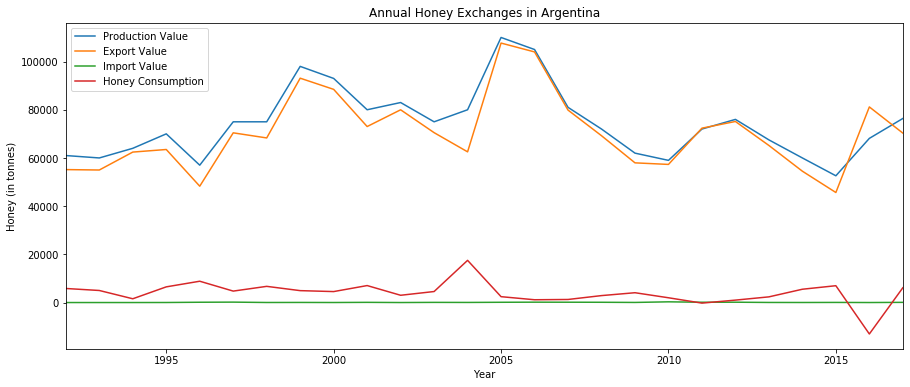

In [26]:
importer_countries = ["Argentina"]
plot_countries_exchanges(exchanges, importer_countries)

6) Country which become exporter

India and Ukraine

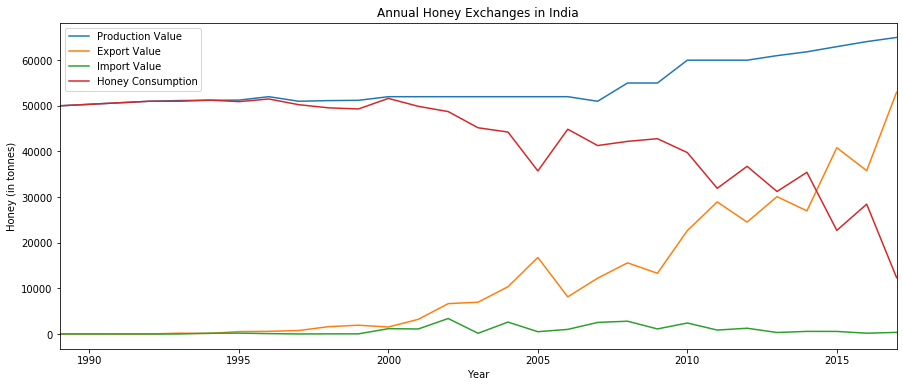

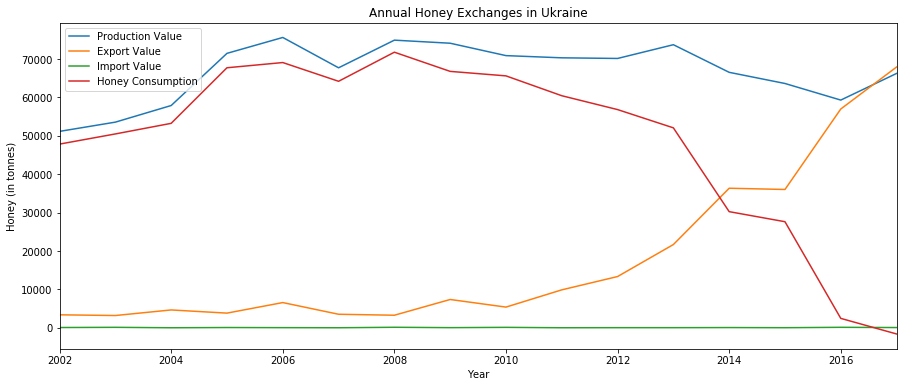

In [27]:
plot_countries_exchanges(exchanges, ["India", "Ukraine"])

We can observe that India until 2000 was self-sufficient and didn't export honey (same for Ukraine until 2012), from this point we can see a trend inversion; indeed the country opened the market to exportations, we can observe that it is more interresting for India (and Ukraine to export Honey than consume it.

##### Conclusion

We can observe honey becomes a bipolar world seperated between producer and consumer. Occidental countries seem to have production issues for the last decades and other countries profited to become big exporters.

#### Matrix Exploration

We now want to explore the entire trade matrix through years. We first decided to do so with folium, however we prefered to use leaflet (javascript) to have more interactivity (It will be nice for our data story).
The goal of this vissualisation is to see which country has which connection with others through time.

In [28]:
#transform a dict into a javascript file compatible with our visualisation
def json_to_js(json_, name):
    f = open(f"exportations_graph/main/data/{name}.js", "w+")
    f.write(f"var {name} = ")
    f.write(str(json_))
    f.write(";")
    f.close()

In [29]:
honey_exports = honey_exports[~(honey_exports == 0).any(axis=1)]

For the moment we will select a year, in the future we will have all years int the visualisation.

In [30]:
year = 2014

In [31]:
honey_exports = honey_exports[honey_exports["Year"] == year]
value_per_country = honey_exports[["Country", "Export Value"]].groupby(["Country"]).agg('sum')
#print (honey_exports[honey_exports["Export Value"] == honey_exports["Export Value"].max()])
value_per_country = value_per_country.to_dict()["Export Value"]

To plot our matrix on a map, we need the borders of each Countries (available in data/countries.geo.json) and the position of the capitals of each country (available in data/capitals.json) to define the begining and the end of each matrix arrow.

In [32]:
countries = json.loads(open('data/countries.geo.json').read())
countries = countries["features"]

capitals = json.loads(open('data/capitals.json').read())
capitals = capitals["features"]

In [33]:
capitals_dict = {}
for capital in capitals:
    capitals_dict[capital["properties"]["country"]] = capital["geometry"]["coordinates"]

The major issue with joining these datasets was the country naming. Indeed since they don't come from the same source, we have different name for the same country (e.g. Russia vs. Russian Federation). So we need a table to translate elements from the country borders json to the capital json (country_to_capital), from country borders to the FAO dataset (country_to_FAO) and one in the other way (FAO_to_country)

In [35]:
country_to_capital = {
    "The Bahamas": "Bahamas",
    "Republic of the Congo": "Congo Republic",
    "Democratic Republic of the Congo": "Congo Democratic Republic",
    "Guinea Bissau":"Guinea-Bissau",
    "South Korea": "Korea South",
    "North Korea": "Korea North",
    "Republic of Serbia" : "Serbia",
    "United Republic of Tanzania" : "Tanzania",
    "United States of America" : "United States"     
             }

country_to_FAO = {
    "The Bahamas": "Bahamas",
    "Ivory Coast": "Côte d'Ivoire",
    "Republic of Serbia" : "Serbia",
    "Republic of the Congo": "Congo Republic",
    "Democratic Republic of the Congo": "Congo Democratic Republic",
    "Guinea Bissau":"Guinea-Bissau",
    "South Korea": "Republic of Korea",
    "North Korea": "Korea North",
    "Dominican Republic":'Dominica',
    "Russia" : "Russian Federation",
    "Czech Republic": "Czechia",
    "Bolivia" : "Bolivia (Plurinational State of)",
    "China" : "China, mainland",
    "Macedonia" : "North Macedonia",
    "Iran" : "Iran (Islamic Republic of)",
    "East Timor": "Timor-Leste",
    "Taiwan" : "China, Taiwan Province of",
    "Moldova" : "Republic of Moldova",
    "Vietnam": "Viet Nam",
    "Syria":"Syrian Arab Republic",
    "Brunei":"Brunei Darussalam"
             }

FAO_to_country = {v: k for k, v in country_to_FAO.items()}

def transform(country, transforms):
    return transforms.get(country, country)

In [37]:
debug = False
countries_json = []
existing_country = []
for elem in countries:
    country = elem["properties"]["name"]
    existing_country.append(country)
    if (transform(country, country_to_capital) not in capitals_dict):
        if debug:
            print(country+" has capital")
        continue
    elif transform(country, country_to_FAO) not in value_per_country :
        if debug:
            print(country + " not export")
        elem["location"] = capitals_dict[transform(country, country_to_capital)]
    else:
        elem["location"] = capitals_dict[transform(country, country_to_capital)]
        elem["value"] = value_per_country[transform(country, country_to_FAO)]
    countries_json.append(elem)
    

In [38]:
exp = honey_exports[["Country", "Partner Countries", "Export Value"]]
exportations_json = []
for i in exp.values.tolist():
    if transform(i[0], FAO_to_country) in existing_country and transform(i[1], FAO_to_country) in existing_country:
        exportations_json.append({"from":transform(i[0], FAO_to_country), "to":transform(i[1], FAO_to_country), "Value":i[2],})
    elif debug :
        print (i[0], i[1])

In [39]:
json_to_js(countries_json, "countries")
json_to_js(exportations_json, "exportations")

You can see the result of the visualsation [here](exportations_graph/main/html/honey_graph.html). You can click on a country to see links to others.

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Tim & Arthur